# Dancing like the Inbetweeners: Learning to Walk with Symphony

Code Notebook By Alex Read - jjxc38

All references in report - main referenced codebases:


[Symphony original implementation
](https://github.com/timurgepard/Simphony)

[TD3 Implementaton
](https://github.com/lukau2357/bipedal-walker-td3)


**Dependencies and setup**

This can take a minute or so...

In [ ]:
%%capture
!pip install setuptools==65.5.0 "wheel<0.40.0"
!apt update
!apt-get install python3-opengl
!apt install xvfb -y
!pip install 'swig'
!pip install 'pyglet==1.5.27'
!pip install 'gym[box2d]==0.20.0'
!pip install 'pyvirtualdisplay==3.0'

import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
from pyvirtualdisplay import Display
from IPython import display as disp
%matplotlib inline


**Additional Setup**
- we use weights & biases for logging
- we use optuna for hyperparameter optimisation
- set seeds/settings early on, to make sure everything is deterministic!
- **select environment normal / hardcore**
- start logging

In [ ]:
!pip install wandb -qU # import wandb for logging
!pip install optuna

import wandb
import copy
import math
import time

#setup wandb
api_key = 'rickrolled'
wandb.login(key=api_key)


display = Display(visible=0,size=(600,600))
display.start()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


plot_interval = 10 # update the plot every N episodes
video_every = 100 # videos can take a very long time to render so only do it every N episodes



# Set seeds nice and early - for consistent results
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.use_deterministic_algorithms(True)
torch.cuda.manual_seed_all(seed)


# Setup logging / Choose enviroment
%load_ext wandb
ENV_NAME = "BipedalWalker-v3" #change to "BipedalWalkerHardcore-v3" for the hardcore enviroment
wandb.init(project=ENV_NAME,save_code=True)

wandb: Currently logged in as: flipperft. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


**Reinforcement learning agent**

We reimplement the actor-critic agent nicknamed '[Symphony](https://github.com/timurgepard/Simphony/tree/main/2_1)' from the book ['How to make Robot move like a Human with Reinforcement Learning'](https://https://www.amazon.co.uk/gp/product/B0CKYWHPF5/ref=ppx_yo_dt_b_d_asin_title_351_o06?ie=UTF8&psc=1).



Loss Functions

The Rectified Huber Error (ReHE)
and Rectified Huber Asymmetrical Error (ReHAE)
$$
\text{ReHAE}(x) = \text{abs}(x) \cdot \tanh(x)
$$



Huber loss distinguishes between small and large errors and combines properties of mean squared error for small errors and mean absolute error for large errors. This Rectified Huber Loss with tanh does a similar thing only with the tanh function. In our experiments, we tried a variety of loss functions.




In [ ]:
# modified huber loss functions
def ReHE(error):
    ae = torch.abs(error).mean()
    return ae*torch.tanh(ae)

def ReHaE(error):
    e = error.mean()
    return torch.abs(e)*torch.tanh(e)

# standard huber loss functions
def hE(error, delta):
    abs_error = torch.abs(error)
    quadratic_part = torch.clamp(abs_error - delta, min=0.0)
    linear_part = delta * (abs_error - 0.5 * delta)
    return torch.mean(0.5 * quadratic_part**2 + linear_part)

def hAE(error, delta):
    abs_error = torch.abs(error)
    return torch.mean(torch.where(abs_error <= delta, 0.5 * error**2, delta * (abs_error - 0.5 * delta)))

Network

The main network architecture uses sine functions, just like a Fourier series! The idea is that neural networks structured as a Fourier series [have been effective in modelling periodic patterns and tasks with cyclical behaviour](https://onlinelibrary.wiley.com/doi/full/10.1002/sam.11531). This network works with the normal bipedal walker great; however, the Fourier series architecture struggles in the hardcore environment which has non-periodic and irregular patterns.









In [ ]:
class ReSine(nn.Module):
    def forward(self, x):
        return F.leaky_relu(torch.sin(x), 0.1)


class Network(nn.Module):
    def __init__(self, hidden_dim, f_out):
        super().__init__()

        self.fft = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            ReSine(),
            nn.Linear(hidden_dim, f_out)
        )

    def forward(self, x):
        return self.fft(x)

Actor

In [ ]:

class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, device, hidden_dim=256, max_action=1.0,exploration_scale_factor=0.2,noise_limit_multiplier = 2.5):
        super(Actor, self).__init__()
        self.device = device

        # transform input observations to match the size of the neural network's input layer
        self.input = nn.Linear(obs_dim, hidden_dim)

        self.net = nn.Sequential(
            Network(hidden_dim, act_dim),
            nn.Tanh() # squashes the output to the range (-1,1)
        )

        # calculate hyperparameters for noise / exploration
        self.exploration_scale_factor = exploration_scale_factor
        self.max_action = torch.mean(max_action).item()
        self.noise_scale = self.exploration_scale_factor*self.max_action # calculate scale for adding noise / exploration
        self.noise_limit = noise_limit_multiplier*self.noise_scale # limit for magnitude of noise


    def forward(self, state):
        x = self.input(state)
        x = self.max_action*self.net(x)
        return x

    def action(self, state):
        self.input.eval()
        with torch.no_grad():
            x = self.forward(state)
            x += (self.exploration_scale_factor*torch.randn_like(x)).clamp(-self.noise_limit, self.noise_limit)
        self.input.train()
        return x.clamp(-self.max_action, self.max_action)


Critic

In [ ]:
class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.input = nn.Linear(obs_dim+act_dim, hidden_dim)
        # Q-value function approximations
        qA = Network(hidden_dim, 1)
        qB = Network(hidden_dim, 1)
        qC = Network(hidden_dim, 1)

        self.nets = nn.ModuleList([qA, qB, qC])


    def forward(self, state, action, united=False):
        x = torch.cat([state, action], -1)
        x = self.input(x)
        xs = [net(x) for net in self.nets]

        # united returns a unified Q-value by taking the minimum across the networks
        if not united: return xs

        # otherwise return a list containing the Q-values calculated by each network
        return torch.min(torch.cat(xs, dim=-1), dim=-1, keepdim=True).values


Agent

In [ ]:
# Define the actor-critic agent
class Agent(object):
    def __init__(self, obs_dim, act_dim, hidden_dim, device, max_action=1.0, fade_factor=7.0, alpha=0.07,exploration_scale_factor=0.2):

        # agent has a replay buffer
        self.replay_buffer = ReplayBuffer(obs_dim, act_dim, device, fade_factor, alpha)

        # setup actor
        self.actor = Actor(obs_dim, act_dim, device, hidden_dim, max_action=max_action,exploration_scale_factor=exploration_scale_factor).to(device)

        # use three critics, two online and one offline critic
        self.critic = Critic(obs_dim, act_dim, hidden_dim).to(device)
        self.critic2 = copy.deepcopy(self.critic)

        self.critic_target = copy.deepcopy(self.critic)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=3e-4)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=3e-4)

        self.max_action = max_action
        self.device = device
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.q_old_policy = 0.0



    def sample_action(self, states):
        with torch.no_grad():
            states = np.array(states)
            state = torch.FloatTensor(states).reshape(-1,self.obs_dim).to(self.device)
            action = self.actor.action(state)
        return action.cpu().data.numpy().flatten()


    def train(self, tr_per_step=1):
        #Update-To-Data (UTD)
        for _ in range(tr_per_step):
            state, action, reward, next_state, done = self.replay_buffer.sample()
            #Sample Multiple Reuse (SMR) #TODO: need to look into this and really just cleanup this function in general
            for _ in range(3):
                self.critic_update(state, action, reward, next_state, done)
            self.actor_update(state)
    # update critic
    def critic_update(self, state, action, reward, next_state, done):
        with torch.no_grad():
            for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
                target_param.data.copy_(0.997*target_param.data + 0.003*param)

            next_action = self.actor(next_state)
            q_next_target = self.critic_target(next_state, next_action, united=True)
            q_value = reward +  (1-done) * 0.99 * q_next_target
        qs = self.critic(state, action, united=False)
        other_qs = self.critic2(state, action, united=False)
        other_critic_loss = ReHE(q_value - qs[0]) + ReHE(q_value - qs[1]) + ReHE(q_value - qs[2])
        critic_loss = ReHE(q_value - qs[0]) + ReHE(q_value - qs[1]) + ReHE(q_value - qs[2])
        critic_loss = min(other_critic_loss, critic_loss)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
    def actor_update(self, state):
        action = self.actor(state)
        q_new_policy = self.critic(state, action, united=True)
        actor_loss = -ReHaE(q_new_policy - self.q_old_policy)

        self.actor_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        self.actor_optimizer.step()

        with torch.no_grad(): self.q_old_policy = q_new_policy.mean().detach()


Replay Buffer
- We use a faded replay - older experiences are valued less

In [ ]:
class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, device, fade_factor=7.0, alpha=0.07,capacity=512000,delta_max=3.0,delta_max_update_threshold=1000):
        self.length = 0 # current length of buffer
        self.device = device
        self.capacity = capacity # represents the maximum number of experiences (state, action, reward, next state, done) that the buffer can store
        self.batch_size = min(max(128, self.length//500), 1024) #   determines how many experiences are sampled from the buffer for each training iteration. It's dynamically set based on the length of the buffer
        self.fade_factor = fade_factor # controls how much older experiences are weighted during sampling
        self.alpha_base = alpha # scales the importance of recent rewards in adjusting the alpha value, which is used in reward correction.
        self.delta_max = delta_max #represents the largest observed difference between consecutive states
        self.delta_max_update_threshold = delta_max_update_threshold # represents a threshold (timesteps) for updating delta_max
        self.alpha = alpha # dynamically adjusted based on the average difference between consecutive states. This adjustment regulates how much the reward correction term affects the overall reward.

        # init vars
        self.indices, self.indexes, self.probs, self.step = [], np.array([]), np.array([]), 0
        self.states = torch.zeros((self.capacity, obs_dim), dtype=torch.float32).to(device)
        self.actions = torch.zeros((self.capacity, act_dim), dtype=torch.float32).to(device)
        self.rewards = torch.zeros((self.capacity, 1), dtype=torch.float32).to(device)
        self.next_states = torch.zeros((self.capacity, obs_dim), dtype=torch.float32).to(device)
        self.dones = torch.zeros((self.capacity, 1), dtype=torch.float32).to(device)
        self.rewards_sum = 0


    # add a memory to the buffer
    def add(self, state, action, reward, next_state, done):

      # if the buffer is not at max size increased its size
        if self.length<self.capacity:
            self.length += 1
            self.indices.append(self.length-1)
            self.indexes = np.array(self.indices)

        idx = self.length-1

        # update running sum of rewards and total step count
        self.rewards_sum += (reward/2)*math.tanh(reward/2)
        self.step += 1


        # update alpha value based on rewards and steps
        self.alpha = self.alpha_base*(10.0 + self.rewards_sum/self.step)/10.0

        # compute delta (mean absolute difference between states)
        delta = np.mean(np.abs(next_state - state)).item()


        # update delta_max if step count is less than or equal to delta_max_update_threshold
        if self.step<=self.delta_max_update_threshold:
            if delta>self.delta_max: self.delta_max = delta

        # normalise and adjust reward using alpha and delta
        delta /= self.delta_max
        reward += self.alpha*(0.5*math.tanh(math.log(2.0*delta))+0.5)

        # store the experience in the buffer
        self.states[idx,:] = torch.FloatTensor(state).to(self.device)
        self.actions[idx,:] = torch.FloatTensor(action).to(self.device)
        self.rewards[idx,:] = torch.FloatTensor([reward]).to(self.device)
        self.next_states[idx,:] = torch.FloatTensor(next_state).to(self.device)
        self.dones[idx,:] = torch.FloatTensor([done]).to(self.device)

        # update batch size based on current buffer length
        self.batch_size = min(max(128, self.length//250), 2048)

        # if buffer is full, roll the buffer to remove the oldest experience
        if self.length==self.capacity:
            self.states = torch.roll(self.states, shifts=-1, dims=0)
            self.actions = torch.roll(self.actions, shifts=-1, dims=0)
            self.rewards = torch.roll(self.rewards, shifts=-1, dims=0)
            self.next_states = torch.roll(self.next_states, shifts=-1, dims=0)
            self.dones = torch.roll(self.dones, shifts=-1, dims=0)


    # produces probabilities of sampling something from the replay buffer - if something is recent it should have a higher probability of being chosen
    def generate_probs(self):
        if self.step>self.capacity: return self.probs
        def fade(norm_index): return np.tanh(self.fade_factor*norm_index**2) # linear / -> non-linear _/‾
        weights = 1e-7*(fade(self.indexes/self.length))# weights are based solely on the history, highly squashed
        self.probs = weights/np.sum(weights)
        return self.probs

    # sample from replay buffer
    def sample(self):
        indices = np.random.choice(self.indexes, p=self.generate_probs(), size=self.batch_size)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices]
        )


    def __len__(self):
        return self.length

**Prepare the environment and wrap it to capture videos**

In [ ]:

%%capture
env = gym.make(ENV_NAME) # env_name is defined at the top of the notebook
# env = gym.make("BipedalWalkerHardcore-v3") # only attempt this when your agent has solved BipedalWalker-v3
env = gym.wrappers.Monitor(env, "./video", video_callable=lambda ep_id: ep_id%video_every == 0, force=True)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]


env.seed(seed)
env.action_space.seed(seed)


In [ ]:
print('The environment has {} observations and the agent can take {} actions'.format(obs_dim, act_dim))
print('The device is: {}'.format(device))

if device.type != 'cpu': print('It\'s recommended to train on the cpu for this')

The environment has 24 observations and the agent can take 4 actions
The device is: cpu


In [ ]:
# used to log data to weights and biases
def log_to_wandb(episode, total_reward_avg, total_reward_std, episode_reward):
  wandb.log({
        'episode': episode,
        'total_reward_avg': total_reward_avg,
        'episode_reward': episode_reward
    })

In [ ]:
explore_time = 500 # time where we don't train, just fill replay buffer
tr_per_step = 5 # actor's updates per frame/step
tr_pre_step = 64 # actor's updates before a frame/step
hidden_dim = 258 # dimensions of network to use
fade_factor = 7 # fading memory factor
alpha = 0.02000001342 # basicially a stall penalty
exploration_scale_factor=0.2 # exploration scale factor

hyperparams = {
    'explore_time': explore_time,
    'tr_per_step': tr_per_step,
    'hidden_dim': hidden_dim,
    'fade_factor': fade_factor,
    'alpha':alpha,
    'exploration_scale_factor':exploration_scale_factor,
    'tr_pre_step':tr_pre_step
}

print("Hyperparamaters being used: ", hyperparams)
wandb.config.update(hyperparams)

Hyperparamaters being used:  {'explore_time': 500, 'tr_per_step': 5, 'hidden_dim': 258, 'fade_factor': 7, 'alpha': 0.02000001342, 'exploration_scale_factor': 0.2, 'tr_pre_step': 64}


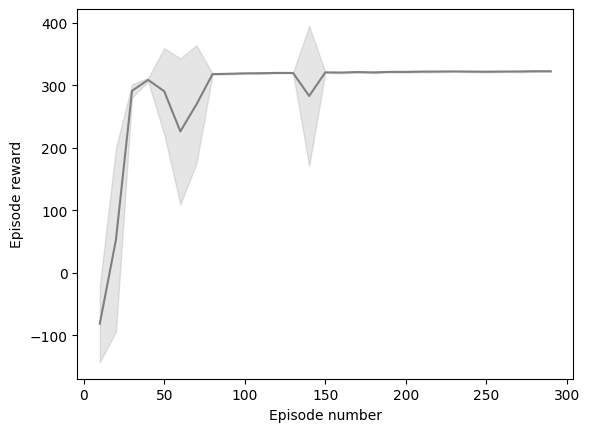

In [ ]:
# needed variables
Q_learning = False
max_action = 1.0
max_action = max_action*torch.FloatTensor(env.action_space.high).to(device) if env.action_space.is_bounded() else max_action*1.0
total_steps = 0


# is used to init weights of the actor - this is still seeded / deterministic!
def init_weights(m):
    if isinstance(m, nn.Linear): torch.nn.init.xavier_uniform_(m.weight)

# chris's logging variables
ep_reward = 0
reward_list = []
plot_data = []
log_f = open("agent-log.txt","w+")

# initialise agent
agent = Agent(obs_dim, act_dim, hidden_dim, device, max_action, fade_factor, alpha,exploration_scale_factor)
max_episodes = 1000
max_timesteps = 2000


# training procedure:
for episode in range(1, max_episodes+1):
    state = env.reset()


    # If the agent is exploring, sample some random weights for it - these are seeded!
    if not Q_learning and total_steps < explore_time:
      agent.actor.apply(init_weights)


    # for some reason got errors without, seems to relieve cpu / gpu
    if Q_learning: time.sleep(0.5)


    for t in range(max_timesteps):
        total_steps += 1


        if t>=explore_time and not Q_learning:
            print("end of exploration")
            Q_learning = True

            agent.train(tr_pre_step)

        action = agent.sample_action(state)


        # take action in environment and get r and s'
        next_state, reward, done, info = env.step(action)


        # add to replay buffer
        agent.replay_buffer.add(state, action, reward, next_state, done)


        if Q_learning:
          agent.train(tr_per_step)

        state = next_state
        ep_reward += reward

        #
        if done or (not Q_learning and t>=2000): break

        # stop iterating when the episode finished
        if done or t==(max_timesteps-1):
            break

    # append the episode reward to the reward list
    reward_list.append(ep_reward)




    # do NOT change this logging code - it is used for automated marking!
    log_f.write('episode: {}, reward: {}\n'.format(episode, ep_reward))
    log_f.flush()

    # log data to wandb
    log_to_wandb(episode,np.array(reward_list).mean(),np.array(reward_list).std(),ep_reward)

    ep_reward = 0

    # print reward data every so often - add a graph like this in your report
    if episode % plot_interval == 0:
        plot_data.append([episode, np.array(reward_list).mean(), np.array(reward_list).std()])
        reward_list = []
        # plt.rcParams['figure.dpi'] = 100
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.show()
        disp.clear_output(wait=True)






In [ ]:
env.close()

Hyperparameter Search Code
- optuna uses Bayesian optimisation

(this was not ran in a notebook)

In [ ]:
import optuna


def objective(trial):
  explore_time = 500 # time where we don't train, fill replay buffer
  tr_per_step = 5 # actor's updates per frame/step
  tr_pre_step = 64 # actor's updates before a frame/step
  hidden_dim = 384 # dimensions of network to use
  fade_factor = 7 # fading memory factor
  alpha = 0.02 # basicially a stall penalty
  exploration_scale_factor=0.2 # exploration scale factor

  hyperparams = {
      'explore_time': explore_time,
      'tr_per_step': tr_per_step,
      'hidden_dim': hidden_dim,
      'fade_factor': fade_factor,
      'alpha':alpha,
      'exploration_scale_factor':exploration_scale_factor,
      'tr_pre_step':tr_pre_step
  }

  explore_time = trial.suggest_int('explore_time', 300, 1000)
  tr_per_step = trial.suggest_int('tr_per_step', 1, 8)
  tr_pre_step = trial.suggest_int('tr_pre_step', 32, 128)
  hidden_dim = trial.suggest_int('hidden_dim', 256,512)
  fade_factor = trial.suggest_categorical('fade_factor', [1, 10,7,100])
  alpha = trial.suggest_float('alpha', 0.01, 0.1)
  exploration_scale_factor = trial.suggest_float('exploration_scale_factor', 0.05, 0.5)



  # needed variables
  Q_learning = False
  max_action = 1.0
  max_action = max_action*torch.FloatTensor(env.action_space.high).to(device) if env.action_space.is_bounded() else max_action*1.0
  total_steps = 0


  # is used to init weights of the actor - this is still seeded / deterministic!
  def init_weights(m):
      if isinstance(m, nn.Linear): torch.nn.init.xavier_uniform_(m.weight)

  # search variable
  total_reward = 0



  # initialise agent
  agent = Agent(obs_dim, act_dim, hidden_dim, device, max_action, fade_factor, alpha,exploration_scale_factor)
  max_episodes = 150
  max_timesteps = 2000


  # training procedure:
  for episode in range(1, max_episodes+1):



      state = env.reset()


      # If the agent is exploring, sample some random weights for it - these are seeded!
      if not Q_learning and total_steps < explore_time:
        agent.actor.apply(init_weights)



      if Q_learning: time.sleep(0.5)


      for t in range(max_timesteps):
          total_steps += 1


          if t>=explore_time and not Q_learning:
              Q_learning = True
              agent.train(tr_pre_step)

          action = agent.sample_action(state)



          next_state, reward, done, info = env.step(action)



          agent.replay_buffer.add(state, action, reward, next_state, done)


          if Q_learning:
            agent.train(tr_per_step)

          state = next_state
          total_reward += reward


          if done or (not Q_learning and t>=2000): break

          # stop iterating when the episode finished
          if done or t==(max_timesteps-1):
              break


  return total_reward


def log_trial_info(study, trial):
    # Open the log file in append mode, creates it if it doesn't exist
    with open("trial_log.txt", "a") as log_file:
        log_file.write(f"Trial {trial.number} finished with total reward: {trial.value}, "
                       f"parameters: {trial.params}")

# Create a study object
study = optuna.create_study(direction='maximize')  # Assuming you want to maximize total_reward
study.optimize(objective, n_trials=100, callbacks=[log_trial_info])


# After all trials, get the best trial information
best_trial = study.best_trial
print(f"Best trial total reward: {best_trial.value}")
print(f"Best trial parameters: {best_trial.params}")



**Reinforcement learning agent (TD3)**

In our paper we compare our modified implementation of simphony with TD3 - below is the code we used to train a TD3 agent.

We used a lot of code from [here](https://github.com/lukau2357/bipedal-walker-td3), this is just a vanilla implementation of TD3

Network
(same for actor and critic - just uses different dimensions)

In [ ]:
class Network(nn.Module):
    def __init__(
        self, shape, output_activation, learning_rate,device):
        super().__init__()
        # initialize the network
        layers = []
        for i in range(1, len(shape)):
            dim1 = shape[i - 1]
            dim2 = shape[i]
            layers.append(nn.Linear(dim1, dim2))
            if i < len(shape) - 1:
                layers.append(nn.ReLU())
        layers.append(output_activation())
        self.network = nn.Sequential(*layers)

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.device = device
        self.to(self.device)

    def forward(self, state):
        return self.network(state)

    def gradient_descent_step(self, loss, retain_graph=False):
        self.optimizer.zero_grad()
        loss.backward(retain_graph=retain_graph)
        self.optimizer.step()

Replay Buffer

In [ ]:
class ReplayBuffer():
    def __init__(self, obs_dim, act_dim, size=1_000_000):
        # use a fixed-size buffer to prevent constant list instantiations
        self.states = np.zeros((size, obs_dim))
        self.actions = np.zeros((size, act_dim))
        self.rewards = np.zeros(size)
        self.next_states = np.zeros((size, obs_dim))
        self.done_flags = np.zeros(size)
        # use a pointer to keep track of where in the buffer we are
        self.pointer = 0
        # use current size to ensure we don't train on any non-existent data points
        self.current_size = 0
        self.size = size

    def store(
        self, state, action, reward, next_state,done_flag):
        # store all the data for this transition
        ptr = self.pointer
        self.states[ptr] = state
        self.actions[ptr] = action
        self.rewards[ptr] = reward
        self.next_states[ptr] = next_state
        self.done_flags[ptr] = done_flag
        # update the pointer and done_flag size
        self.pointer = (self.pointer + 1) % self.size
        self.current_size = min(self.current_size + 1, self.size)

    def get_mini_batch(self, size):
        # ensure size is not bigger than the current size of the buffer
        size = min(size, self.current_size)
        # generate random indices
        indices = np.random.choice(self.current_size, size, replace=False)
        # return the mini-batch of transitions
        return {
            "states": self.states[indices],
            "actions": self.actions[indices],
            "rewards": self.rewards[indices],
            "next_states": self.next_states[indices],
            "done_flags": self.done_flags[indices],
        }

Agent

In [ ]:

from copy import deepcopy

class Agent():
    def __init__(
        self, obs_dim,act_dim, learning_rate, gamma, tau, cycle_num=-1):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.gamma = gamma
        self.tau = tau
        self.cycle_num = cycle_num



        self.device = torch.device('cpu')
        self.buffer = ReplayBuffer(self.obs_dim, self.act_dim)


        # initialize the actor and critics
        self.actor = Network([self.obs_dim, 400, 300, self.act_dim],nn.Tanh,learning_rate,self.device)

        self.critic1 = Network([self.obs_dim + self.act_dim, 400, 300, 1],nn.Identity,learning_rate,self.device)

        self.critic2 = Network([self.obs_dim + self.act_dim, 400, 300, 1],nn.Identity,learning_rate,self.device)

        # create target networks
        self.target_actor = deepcopy(self.actor)

        self.target_critic1 = deepcopy(self.critic1)

        self.target_critic2 = deepcopy(self.critic2)

    def sample_action(self, state, sigma):

        deterministic_action = self.get_deterministic_action(state)
        noise = np.random.normal(0, sigma, deterministic_action.shape)
        return np.clip(deterministic_action + noise, -1, +1)

    def get_deterministic_action(self, state):
        actions: torch.Tensor = self.actor.forward(torch.tensor(state, device=self.device))
        return actions.cpu().detach().numpy()

    def update(self, mini_batch_size, training_sigma, training_clip,update_policy):
        # randomly sample a mini-batch from the replay buffer
        mini_batch = self.buffer.get_mini_batch(mini_batch_size)
        # create tensors to start generating computational graph
        states = torch.tensor(mini_batch["states"], requires_grad=True, device=self.device)
        actions = torch.tensor(mini_batch["actions"], requires_grad=True, device=self.device)
        rewards = torch.tensor(mini_batch["rewards"], requires_grad=True, device=self.device)
        next_states = torch.tensor(
            mini_batch["next_states"], requires_grad=True, device=self.device
        )
        dones = torch.tensor(mini_batch["done_flags"], requires_grad=True, device=self.device)
        # compute the targets
        targets = self.compute_targets(
            rewards, next_states, dones, training_sigma, training_clip
        )
        # do a single step on each critic network
        Q1Loss = self.compute_qloss(self.critic1, states, actions, targets)
        self.critic1.gradient_descent_step(Q1Loss, True)
        Q2Loss = self.compute_qloss(self.critic2, states, actions, targets)
        self.critic2.gradient_descent_step(Q2Loss)
        if update_policy:
            # do a single step on the actor network
            policy_loss = self.compute_policy_loss(states)
            self.actor.gradient_descent_step(policy_loss)
            # update target networks
            self.update_target_network(self.target_actor, self.actor)
            self.update_target_network(self.target_critic1, self.critic1)
            self.update_target_network(self.target_critic2, self.critic2)

    def compute_targets(self, rewards, next_states, dones,training_sigma, training_clip):
        target_actions = self.target_actor.forward(next_states.float())
        # create additive noise for target actions
        noise = np.random.normal(0, training_sigma, target_actions.shape)
        clipped_noise = torch.tensor(
            np.clip(noise, -training_clip, +training_clip), device=self.device
        )
        target_actions = torch.clip(target_actions + clipped_noise, -1, +1)
        # compute targets
        target_Q1_values = torch.squeeze(
            self.target_critic1.forward(torch.hstack([next_states, target_actions]).float())
        )
        target_Q2_values = torch.squeeze(
            self.target_critic2.forward(torch.hstack([next_states, target_actions]).float())
        )
        target_Q_values = torch.minimum(target_Q1_values, target_Q2_values)
        return rewards + self.gamma*(1 - dones)*target_Q_values

    def compute_qloss(
        self, network, states, actions, targets):
        # compute the MSE of the Q function with respect to the targets
        Q_values = torch.squeeze(network.forward(torch.hstack([states, actions]).float()))
        return torch.square(Q_values - targets).mean()

    def compute_policy_loss(self, states):
        actions = self.actor.forward(states.float())
        Q_values = torch.squeeze(self.critic1.forward(torch.hstack([states, actions]).float()))
        return -Q_values.mean()

    def update_target_network(self, target_network, network):
        with torch.no_grad():
            for target_parameter, parameter in zip(
                target_network.parameters(), network.parameters()
            ):
                target_parameter.mul_(1 - self.tau)
                target_parameter.add_(self.tau*parameter)


Hyperparams

In [ ]:
# hyperparamaters - original ones
gamma = 0.99         # discount factor for rewards
learningRate = 3e-4  # learning rate for actor and critic networks
tau = 0.005          # tracking parameter used to update target networks slowly
actionSigma = 0.1    # contributes noise to deterministic policy output
trainingSigma = 0.2  # contributes noise to target actions
trainingClip = 0.5   # clips target actions to keep them close to true actions
miniBatchSize = 100  # how large a mini-batch should be when updating
policyDelay = 2      # how many steps to wait before updating the policy


# hyperparamters we found through search
gamma= 0.9631181910550325
learning_rate= 0.00048294207603125734
tau = 0.0026831631289759876
action_sigma=0.10499796824145134
training_sigma=0.2723359263110223
training_clip = 0.49988955249436184
mini_batch_size=107
policy_delay=3

In [ ]:

# Setup logging / Choose enviroment
%load_ext wandb
ENV_NAME = "BipedalWalker-v3" #change to "BipedalWalkerHardcore-v3" for the hardcore enviroment
wandb.init(project=ENV_NAME,save_code=True)

env = gym.make(ENV_NAME)
# env = gym.make("BipedalWalkerHardcore-v3") # only attempt this when your agent has solved BipedalWalker-v3
env = gym.wrappers.Monitor(env, "./video", video_callable=lambda ep_id: ep_id%video_every == 0, force=True)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]


plot_interval = 10 # update the plot every N episodes
video_every = 100 # videos can take a very long time to render so only do it every N episodes


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Set seeds nice and early - for consistent results
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.use_deterministic_algorithms(True)
torch.cuda.manual_seed_all(seed)

In [ ]:

# logging variables
ep_reward = 0
reward_list = []
plot_data = []

# we dont submit the this - can only submit one agent log
# log_f = open("agent-log.txt","w+")

# initialise agent
agent = Agent(obs_dim,act_dim,learningRate, gamma, tau)
max_episodes = 1000
max_timesteps = 2000




# training procedure:
for episode in range(1, max_episodes+1):
    state = env.reset()
    for t in range(max_timesteps):

        action = agent.sample_action(state, action_sigma)


        next_state, reward, done, _ = env.step(action)

        agent.buffer.store(state, action, reward, next_state, done)

        state = next_state
        ep_reward += reward


        should_update_policy = t % policy_delay == 0

        agent.update(mini_batch_size, training_sigma, training_clip, should_update_policy)



        # stop iterating when the episode finished
        if done or t==(max_timesteps-1):
            break

    # append the episode reward to the reward list
    reward_list.append(ep_reward)

    # do NOT change this logging code - it is used for automated marking! - we dont use this file for submission!
    # log_f.write('episode: {}, reward: {}\n'.format(episode, ep_reward))
    # log_f.flush()


    # log data to wandb
    log_to_wandb(episode,np.array(reward_list).mean(),np.array(reward_list).std(),ep_reward)

    ep_reward = 0

    # print reward data every so often - add a graph like this in your report
    if episode % plot_interval == 0:
        plot_data.append([episode, np.array(reward_list).mean(), np.array(reward_list).std()])
        reward_list = []
        # plt.rcParams['figure.dpi'] = 100
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.show()
        disp.clear_output(wait=True)


env.close()

Hyperparam search

This also wasn't ran in a notebook

In [ ]:
def objective(trial, env):
    score = 0

    # HYPERPARAMETERS
    gamma = 0.99         # discount factor for rewards
    learningRate = 3e-4  # learning rate for actor and critic networks
    tau = 0.005          # tracking parameter used to update target networks slowly
    actionSigma = 0.1    # contributes noise to deterministic policy output
    trainingSigma = 0.2  # contributes noise to target actions
    trainingClip = 0.5   # clips target actions to keep them close to true actions
    miniBatchSize = 100  # how large a mini-batch should be when updating
    policyDelay = 2      # how many steps to wait before updating the policy


    gamma = trial.suggest_float('gamma', 0.9, 0.999, log=True)  # discount factor for rewards
    learningRate = trial.suggest_float('learningRate', 1e-5, 1e-3, log=True)  # learning rate for actor and critic networks
    tau = trial.suggest_float('tau', 0.001, 0.01, log=True)  # tracking parameter used to update target networks slowly
    actionSigma = trial.suggest_float('actionSigma', 0.05, 0.2)  # contributes noise to deterministic policy output
    trainingSigma = trial.suggest_float('trainingSigma', 0.1, 0.3)  # contributes noise to target actions
    trainingClip = trial.suggest_float('trainingClip', 0.1, 1.0)  # clips target actions to keep them close to true actions
    miniBatchSize = trial.suggest_int('miniBatchSize', 32, 120)  # how large a mini-batch should be when updating
    policyDelay = trial.suggest_int('policyDelay', 1, 5)  # how many steps to wait before updating the policy


    """**Prepare the environment and wrap it to capture videos**"""

    # Commented out IPython magic to ensure Python compatibility.
    # %%capture

    # # env = gym.make("BipedalWalkerHardcore-v3") # only attempt this when your agent has solved BipedalWalker-v3
    # env = gym.wrappers.Monitor(env, "./video", video_callable=lambda ep_id: ep_id%video_every == 0, force=True)
    #
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    print('The environment has {} observations and the agent can take {} actions'.format(obs_dim, act_dim))
    print('The device is: {}'.format(device))

    if device.type != 'cpu': print('It\'s recommended to train on the cpu for this')

    # in the submission please use seed 42 for verification
    seed = 42
    torch.manual_seed(seed)

    random.seed(seed)
    np.random.seed(seed)
    env.seed(seed)
    env.action_space.seed(seed)

    # logging variables
    ep_reward = 0
    reward_list = []
    plot_data = []

    # initialise agent
    agent = Agent("plz",obs_dim,act_dim,learningRate, gamma, tau)
    max_episodes = 300
    max_timesteps = 2000

    # training procedure:
    for episode in range(1, max_episodes+1):
        print("on episode: ", episode)
        state = env.reset()
        for t in range(max_timesteps):

            # select the agent action

            action = agent.sample_action(state, actionSigma)

            next_state, reward, done, info = env.step(action)

            agent.buffer.store(state, action, reward, next_state, done)

            state = next_state
            ep_reward += reward

            shouldUpdatePolicy = t % policyDelay == 0

            agent.update(miniBatchSize, trainingSigma, trainingClip, shouldUpdatePolicy)

            # stop iterating when the episode finished
            if done or t==(max_timesteps-1):
                break

        # append the episode reward to the reward list
        score += ep_reward
        reward_list.append(ep_reward)
        ep_reward = 0

        # print reward data every so often - add a graph like this in your report
        if episode % plot_interval == 0:
            plot_data.append([episode, np.array(reward_list).mean(), np.array(reward_list).std()])
            # plt.rcParams['figure.dpi'] = 100
            log_to_wandb(plot_data)
    return score


study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, env), n_trials=200)
wandb.finish()


